### Import Required Libraries
---

In [32]:
import os
import random
import time
import platform
import requests

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn, optim

from torch.optim import lr_scheduler

from torchvision import transforms, models, datasets, utils

### Work in Colab or Local

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Debug
print(IN_COLAB)
if IN_COLAB:
  model_path = '/content/drive/My Drive/exp-fer_p3_01/'
  from google.colab import drive
  drive.mount('/content/drive')

True
Mounted at /content/drive


### Model Architectures
---

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(device))


Device: cuda


### Model Architecture Definition
---

In [5]:
ARCH_NAME = 'resnet18'

if ARCH_NAME == 'simplenet':
    # Simple net
    model = Net(3, 5)

elif ARCH_NAME == 'alexnet':
    # Pretrainned
    model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
    ### model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
    # Changes the number of neurons in the output layer.
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 5)

elif ARCH_NAME == 'resnet18':
    model = models.resnet18(pretrained=True).to(device)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 5).to(device)

elif ARCH_NAME == 'mobilenetv2':
    model = CustomMobileNetv2(output_size=5).to(device)

# Include more architectures...
# ---
### elif ARCH_NAME == ...

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


### Load Model From Path
---

In [ ]:
model_path = 'data/exp-fer_p3_01/'

model.load_state_dict(torch.load(os.path.join(model_path, f"fer-classification-{ARCH_NAME}-model.pth")))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Model Parameters
---

In [8]:
# Calculate and print the total number of trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_trainable_params}")


Total trainable parameters: 11179077


### Define data transform

In [44]:
data_transform = transforms.Compose([
    # It is necessary to resize the image to match the network's input size.
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # Mean and standard deviation of ImageNet
    # These are required as we will use a model pre-trained on ImageNet.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Create Test Loader for Model Inference

In [45]:
if IN_COLAB:
  ds_path = '/content/drive/My Drive/Data/faces-emotion-recognition/faces/'
else:
  ds_path = '/home/'

In [46]:
batch_size = 64
test_set = datasets.ImageFolder(ds_path+'test', transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [47]:
classes = test_set.classes

### GPU Pre-Heating

In [17]:
# Pré-aquecimento da GPU (só se tiver CUDA disponível)
if device.type == "cuda":
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224, device=device)
        _ = model(dummy)

### Model Test
---

In [18]:
labels_true = []
labels_pred = []

model.eval()

with torch.no_grad():
  for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)

    # pred = outputs.data.max(1, keepdim=True)[1]

    labels_pred.extend(outputs.cpu().numpy())
    labels_true.extend(labels.cpu().numpy())

labels_pred = np.array(labels_pred)
labels_true = np.array(labels_true)

100%|██████████| 50/50 [15:39<00:00, 18.79s/it]


### Confusion Matrix
---

In [26]:
# Get the index of max probabilities
labels_pred_argmax = np.argmax(labels_pred, axis=1)
print("True Labels: ", labels_true[:10])
print("True Labels: ", labels_pred_argmax[:10])

True Labels:  [4 0 0 1 2 0 3 1 0 4]
True Labels:  [1 1 0 1 2 0 3 1 0 4]


In [38]:
cm = metrics.confusion_matrix(labels_true, labels_pred_argmax)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[271  47  11  35  54]
 [ 74 430  29  88 102]
 [ 14  16 790  56  15]
 [ 24  29  50 337  79]
 [ 62  97  30  94 336]]


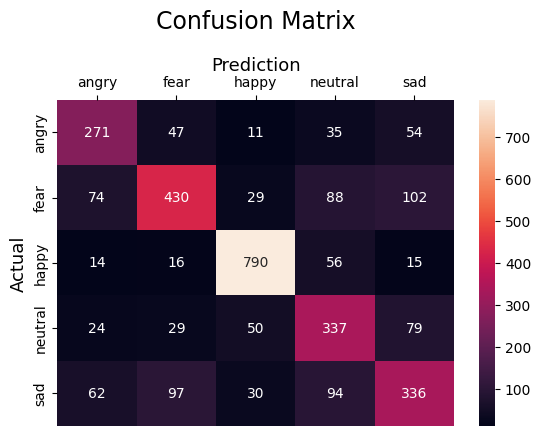

In [39]:
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=classes,
            yticklabels=classes)
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

### Classification Report
---

In [42]:
cr = metrics.classification_report(y_true=labels_true, y_pred=labels_pred_argmax, target_names=classes)
print("Classification Report")
print(cr)

Classification Report
              precision    recall  f1-score   support

       angry       0.61      0.65      0.63       418
        fear       0.69      0.59      0.64       723
       happy       0.87      0.89      0.88       891
     neutral       0.55      0.65      0.60       519
         sad       0.57      0.54      0.56       619

    accuracy                           0.68      3170
   macro avg       0.66      0.66      0.66      3170
weighted avg       0.69      0.68      0.68      3170



### Image Inference
---

In [48]:
# Load your image
image_url = "https://i.guim.co.uk/img/static/sys-images/Guardian/Pix/pictures/2008/06/15/fear460.jpg?width=465&dpr=1&s=none&crop=none"
# image = Image.open(image_path).convert("RGB") # Ensure RGB format
image = Image.open(requests.get(image_url, stream=True).raw)

# Apply the transform
transformed_image = data_transform(image)

# Add a batch dimension if your model expects batched input
# (e.g., for a single image, shape will be [1, C, H, W])
input_tensor = transformed_image.unsqueeze(0)

In [49]:
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [50]:
input_tensor = input_tensor.to(device)

In [51]:
class_mapping = [
    "angry",
    "fear",
    "happy",
    "neutral",
    "sad"
]

In [52]:
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_index = torch.argmax(output, dim=1).item()

    print(output)
print("Predicted class:", class_mapping[predicted_index])

tensor([[-3.0468,  7.3649, -6.8456, -7.2370, -9.1667]], device='cuda:0')
Predicted class: fear
